# Choosing a kernel for your GP
The critical piece for a Gaussian process is the kernel function that specifies how the covariance matrix looks. You can read all about how to choose them [here](http://www.cs.toronto.edu/~duvenaud/cookbook/index.html). In this notebook I'll actually show you what happens when you choose different kernels for different problems, and what the effects are.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import george
import george.kernels as kernels
np.random.seed(123456)

## Kernel should resemble the data
In the kernel cookbook I linked, a general piece of advice is that you will get better performace from your GP/emulator if the kernel looks like your data, so using a periodic kernel for a periodic function is better than using the squared exponential function.
Let's start by messing with the Hogg data again and seeing what happens with different kernels.

In [3]:
data = np.genfromtxt("data.txt", skip_header=1, delimiter='&')

#These functions return the different parts of the
#Hogg data, specifically the 'good' and 'bad' sections.
def good_data():
    return data[4:,1:4].T

def bad_data():
    return data[:4, 1:4].T

def all_data():
    return np.concatenate((bad_data().T, good_data().T)).T

Optimization terminated successfully.


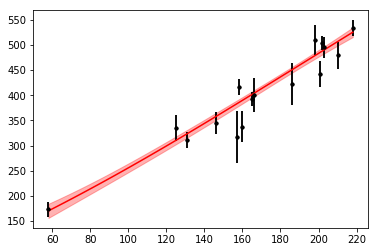

In [4]:
#Obtain and plot the data
x, y, yerr = good_data()
plt.errorbar(x, y, yerr, ls='', marker='.', c='black')
#Create a GP with the SE kernel, optimize, and then predict
kernel = kernels.ConstantKernel(1.0)*kernels.ExpSquaredKernel(1.0)
gp = george.GP(kernel)
gp.compute(x, yerr)
op_result = gp.optimize(x, y, yerr)
d = np.linspace(min(x), max(x), 100)
mu, cov = gp.predict(y, d)
err = np.sqrt(np.diag(cov))
plt.errorbar(x, y, yerr, ls='', marker='.', c='black')
plt.plot(d, mu, c='r')
plt.fill_between(d, mu+err, mu-err, color='r', alpha=0.3)

This is the same GP we created in the last example. Let's see what happens when we make a simple change and use the squared exponential kernel *without* including the $k_o$ variance as a hyperparameter, so now
$$k(x_i,x_j) = \exp\left(-\frac{(x_i-x_j)^2}{2\sigma^2}\right). $$

Optimization terminated successfully.


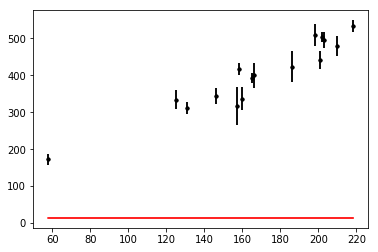

In [5]:
#Obtain and plot the data
x, y, yerr = good_data()
plt.errorbar(x, y, yerr, ls='', marker='.', c='black')
#Create a GP with the SE kernel without variance, optimize, and then predict
kernel = kernels.ExpSquaredKernel(1)
gp = george.GP(kernel)
gp.compute(x, yerr)
op_result = gp.optimize(x, y, yerr)
d = np.linspace(min(x), max(x), 100)
mu, cov = gp.predict(y, d)
err = np.sqrt(np.diag(cov))
plt.errorbar(x, y, yerr, ls='', marker='.', c='black')
plt.plot(d, mu, c='r')
plt.fill_between(d, mu+err, mu-err, color='r', alpha=0.3)

Womp womp womp... The emulator fell on its face and failed miserably. This is because without the $k_0$ parameter out front to scale the covariance between everything the GP cannot handle this set of data. The good news is that this is a common enough problem that there is a fix! Oftentimes when working with GPs a very common thing to do is rescale your $y$ data so that it has unit variance and no mean, and then when the GP makes a prediction again you can just rescale and then add the mean back on.

Optimization terminated successfully.


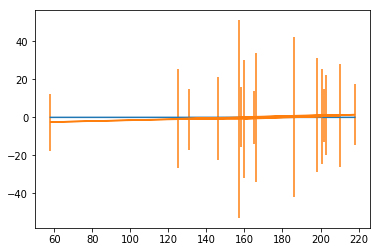

92.2840172714 400.6875


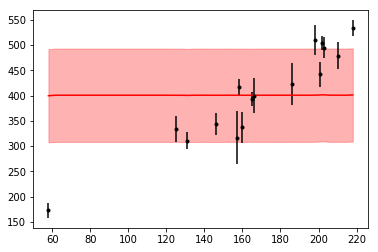

In [13]:
#Obtain and plot the data
x, y_initial, yerr_initial = good_data()
y_mean = np.mean(y_initial)
y_std = np.std(y_initial)
y = (y_initial - y_mean)/y_std
y_err = yerr_initial/y_std
#Create a GP with the SE kernel without variance, optimize, and then predict
kernel = kernels.ExpSquaredKernel(1)
gp = george.GP(kernel)
gp.compute(x, yerr)
op_result = gp.optimize(x, y, yerr)
d = np.linspace(min(x), max(x), 100)
mu, cov = gp.predict(y, d)
plt.plot(d, mu)
plt.errorbar(x, y, yerr)
plt.show()
print y_std, y_mean
mu *= y_std
mu += y_mean
err = np.sqrt(np.diag(cov))*y_std
plt.errorbar(x, y_initial, yerr_initial, ls='', marker='.', c='black')
plt.plot(d, mu, c='r')
plt.fill_between(d, mu+err, mu-err, color='r', alpha=0.3)